In [1]:
# module imports
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import KFold
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.dataset import Subset
from dataset import BigGenomeDataset
from dataloaders import BatchedGenomeDataLoader
from models import ParallelEdeepVPP

In [2]:
# hyper parameters
max_epoch = 50
batch_size = 1000
vocab_size = 5 # A, C, G, T, N
embed_dim = 5
out_size = 2

In [3]:
# train data
train_path = "../data/fullset_train.csv"
train_set = BigGenomeDataset(train_path)
train_dataloader = BatchedGenomeDataLoader(train_set, batch_size=batch_size)

In [4]:
# criterion
# weight = torch.tensor([25.0, 1.0]).cuda()
criterion = nn.BCEWithLogitsLoss()

In [5]:
# model & optimizer
model = ParallelEdeepVPP(vocab_size, embed_dim, out_size=out_size).cuda()
optimizer = optim.Adam(model.parameters())

In [6]:
# training
model.train()
for epoch in range(max_epoch):
    total_loss, count = 0, 0

    for x, t in train_dataloader:
        optimizer.zero_grad()
        y = model(x)
        loss = criterion(y, t)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.data
        count += 1

    avg_loss = total_loss/count

    if epoch%10 == 9:
        print("| epoch %d | loss %f" % (epoch + 1, avg_loss))

| epoch 10 | loss 0.008872
| epoch 20 | loss 0.002458
| epoch 30 | loss 0.001505
| epoch 40 | loss 0.001255
| epoch 50 | loss 0.001339


In [7]:
# test data
test_path = "../data/fullset_test.csv"
test_set = BigGenomeDataset(test_path)
test_dataloader = BatchedGenomeDataLoader(test_set, batch_size=batch_size)

[[25837    17]
 [  527    24]]
正解率:  0.9793978413179322
適合率:  0.5853658536585366
再現率:  0.043557168784029036
F1値:  0.08108108108108107


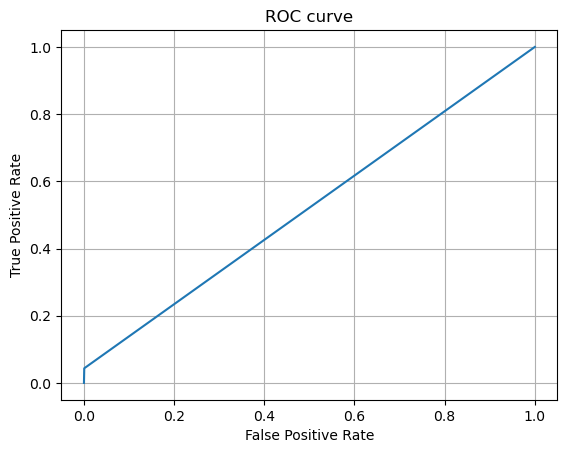

AUC-ROC:  0.5214498151493442


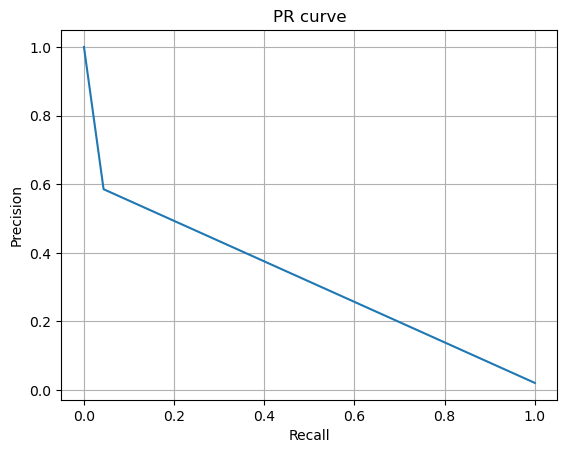

AUC-PR:  0.32444068183290936


In [11]:
# test
batch_count = 0

model.eval()
with torch.no_grad():
    ts = torch.Tensor().cuda()
    ps = torch.Tensor().cuda()

    for x, t in test_dataloader:
        y = model(x)
        p = torch.sigmoid(y)

        t_tmp = t
        p_tmp = p

        if test_dataloader.iteration == 0:
            ts = t_tmp
            ps = p_tmp
        else:
            ts = torch.cat((ts, t_tmp), dim=0)
            ps = torch.cat((ps, p_tmp), dim=0)

    label = ts[:, 0].cpu()
    probability = ps[:, 0].cpu()
    y_pred = ps.argmin(dim=1).cpu()
    
    # confusion matrix
    conf_matrix = metrics.confusion_matrix(label, y_pred)
    print(conf_matrix)
    """
                        Predicted
                    Negative  Positive
    Actual Negative     TN        FP
           Positive     FN        TP
    
    """
    print("正解率: ", metrics.accuracy_score(label, y_pred))
    print("適合率: ", metrics.precision_score(label, y_pred))
    print("再現率: ", metrics.recall_score(label, y_pred))
    print("F1値: ", metrics.f1_score(label, y_pred))

    # ROC-AUC
    fpr, tpr, thresholds = metrics.roc_curve(label, y_pred)
    plt.plot(fpr, tpr, label="ROC curve")
    plt.title("ROC curve")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.show()
    print("AUC-ROC: ", metrics.roc_auc_score(label, y_pred))

    # PR-AUC
    precision, recall, thresholds = metrics.precision_recall_curve(label, y_pred)
    auc = metrics.auc(recall, precision)
    plt.plot(recall, precision, label="PR curve")
    plt.title("PR curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.grid(True)
    plt.show()
    print("AUC-PR: ", auc)